# 2/27/15 Wemo Data
We collected `time`, `sensor_id`, and `current_power` for five sensors. `Current_power` is measured initially in milliwatts, but we convert to watts with floating point precision to make analysis easier.
- `WeMo1` was connected to a space heater in a medium-sized office.
- `WeMo3` was not connected to anything.
- `WeMo4` was connected to a desktop computer in a medium-sized office.
- `WeMo5` was connected to a powered off device, then disconnected during the test.
- `WeMo6` was connected to a powered off fan.

## Questions
1. How many sensor readings are `0`?
2. What was the max power reading per sensor?
3. What was the average power reading per sensor?
4. Were there large jumps in the power readings?

In [1]:
# Imports
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.__version__

Populating the interactive namespace from numpy and matplotlib


'0.15.2'

In [2]:
# Read in data from csv file.
columns = ["time", "sensor", "power"]
path = "15-2-27-wemo.csv"
dateparse = lambda x: pd.datetime.fromtimestamp(float(x))
data = pd.read_csv(path, names=columns, parse_dates=[0], date_parser=dateparse, index_col='time')

In [3]:
data.head()

,sensor,power
time,,
2015-02-27 20:03:12.240000,WeMo5,0
2015-02-27 20:03:12.269999,WeMo4,25640
2015-02-27 20:03:12.339999,WeMo6,360
2015-02-27 20:03:12.470000,WeMo1,159335
2015-02-27 20:03:12.579999,WeMo3,0


In [4]:
# Convert power from mW to just Watts.
data['power'] /= 1000
data.head()

,sensor,power
time,,
2015-02-27 20:03:12.240000,WeMo5,0.000
2015-02-27 20:03:12.269999,WeMo4,25.640
2015-02-27 20:03:12.339999,WeMo6,0.360
2015-02-27 20:03:12.470000,WeMo1,159.335
2015-02-27 20:03:12.579999,WeMo3,0.000


In [5]:
print("{} total readings\n{} have power == 0\n{:2.2f}% are zero entries".format(
        len(data), len(data[data.power == 0]), len(data[data.power == 0]) / len(data) * 100))

78875 total readings
20388 have power == 0
25.85% are zero entries


In [6]:
# We want to see if any sensors only recorded zero values.
#   First we group the data by sensor, then we count the number
#   of recordings that are zero. If `num_zero_readings == num_readings`,
#   then we should ignore that sensor data.
print("Are all of the readings zero?")
grouped = data.groupby(data.sensor)
counts = grouped.apply(lambda x: x[x['power'] == 0]['power'].count())
counts == grouped.count()['power']

Are all of the readings zero?


sensor
WeMo1     False
WeMo3      True
WeMo4     False
WeMo5      True
WeMo6     False
dtype: bool

### How many sensor readings are `0`?
As we can see, `WeMo3` and `WeMo5` only recorded 0 values, revealing that no device was attached to them. Let's drop them to make the data easier to handle.

In [7]:
# Remove all `Wemo3` and `WeMo5` data.
non_zero = data.drop(grouped.get_group("WeMo3").index)
non_zero = non_zero.drop(grouped.get_group("WeMo5").index)

In [8]:
# Group data by sensor
groups = non_zero.groupby(non_zero.sensor)

In [9]:
groups.describe()

power
sensor                    
WeMo1  count  20396.000000
       mean     139.751982
       std       18.992480
       min      123.760000
       25%      125.930000
       50%      127.000000
       75%      153.395000
       max      186.740000
WeMo4  count  19937.000000
       mean      25.687404
       std        0.065732
       min       25.490000
       25%       25.640000
       50%       25.690000
       75%       25.735000
       max       25.845000
WeMo6  count  18154.000000
       mean       0.354440
       std        0.016727
       min        0.300000
       25%        0.345000
       50%        0.355000
       75%        0.365000
       max        0.415000

sensor
WeMo1     Axes(0.125,0.2;0.775x0.7)
WeMo4     Axes(0.125,0.2;0.775x0.7)
WeMo6     Axes(0.125,0.2;0.775x0.7)
dtype: object

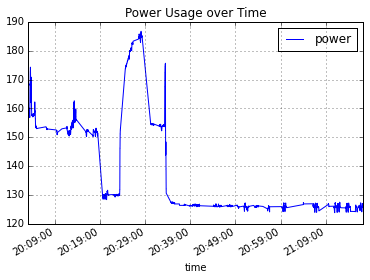

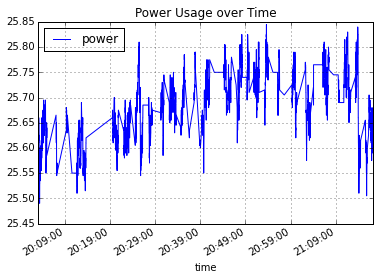

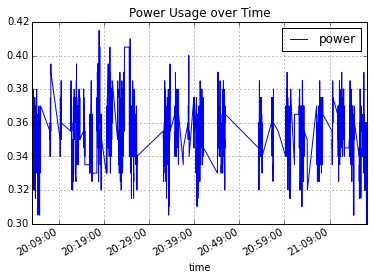

In [10]:
groups.plot(title="Power Usage over Time")

### Were there large jumps in the power readings?
Yes and no. `WeMo1` had huge spikes in usage in around the middle of the data collection phase. Then, it maintained a constant usage of about 1280 Watts.

`WeMo4` steadily increased over time.

`WeMo6` was connected to a power off fan, revealing that it still used a few watts of power. However, we have not personally tested the accuracy of the WeMo, so it is possible that at lower power usage, the device becomes less accurate and more prone to fluctuations.

All of the graphs show that the there is some fluctuation around the data recordings. This could mean that the WeMo sensors have some inherent fluctuation in their measurements. Or, this could represent the powerline fluctuations inherent to the electricity usage of the building. As the researchers use a variable amount of power on this floor in the building, it could be that we can detect these variations in the data. Finally, these variations may be explained by the devices themselves, as the electricity regulators in these devices may not be entirely accurate (or this could be by design).

## Conclusion
There is still more work to do. Areas important for further research are:
- measuring the small variations in energy usage discussed above.
- peak / valley detection in usage. What caused these events?
- disaggregation: can we piece apart different devices connected to a power strip.

To answer these questions and others posed in this analysis, we need to pay better attention to the details of this experiment:
- record the exact devices used
- record notable events in their usage (power on, power off, heavy usage, etc.)